# Aplicación de GMM para clustering -> Segmentación 

## David Felipe Martinez Castiblanco

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.mixture import GaussianMixture

%matplotlib inline

np.random.seed(42)

La siguiente imagen es un linfocito normal de la sangre periférica

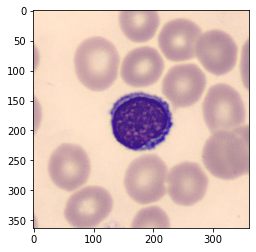

In [4]:
image = Image.open("linfo.jpg")
plt.imshow(image);

In [5]:
# Convierte la imagen a un array de numpy
im = np.asarray(image)
print(im.shape)

(363, 360, 3)


1. Utilice un modelo GMM para segmentar la imagen del linfocito en tres regiones. El resultado debe ser tres imágenes correspondientes a las probabilidades posteriores de las agrupaciones generadas con el modelo de GMM.

Sugerencia. Recuerde que cada pixel de la imagen está compuesta por tres valores R,G,B. Para convertir la imagen a un conjunto de datos de n filas x 3 columnas, utilice `np.reshape()` y de ahí podra usar el modelo GMM. Posteriormente, también deberar usar el reshape para volver cada columna de las probabilidades en una imagen de escala de grises con un tamaño de 363x360 (note que cada columna es solo es una matriz, porque es de escala de grises).

2. Varie el tipo de covarianza mediante el parámetro del model `covariance_type` y determine "visualmente" que tipo de covarianza funciona mejor para la segmentación.

3. Con el tipo de varianza escogida, mediante la métrica BIC o AIC (es un método del modelo) determine si es mejor tener 3 o 4 clusters. Compruebelo visualmente.

4. ¿Por qué el núcleo no se logra segmentar? ¿Cómo podría lograr segmentar el núcleo (de forma simple)? Compruebelo. 

5. Realice la segmentación para las imágenes de la carpeta `test_set`. Visualize las segmentaciónes (un sólo grid) y grafique la métrica de AIC o BIC (por ejm barras).

Nota: La segmentación que estamos realizando es no supervisada. Esto quiere decir, que para cada imagen se crea un modelo y se predicen las probabilidades posteriores de esa imagen. Es posible (y es fácil con sklearn) realizar un modelo no-supervisado a partir de los pesos y responsabilidades encontrados con una o varias imágenes y luego realizar la predicción con otras nuevas. Pero, en este ejercicio no lo estamos realizando así.

Nota 2: Es posible también obtener regiones segmentadas no suaves (usando `model.predict`). Sería interesante graficar dichas regiones con transparencia o bordes sobre las imágenes originales, para propósitos de visualización. Pero no es necesario para este ejercicio.

Nota 3: Es posible evaluar la segmentación de una forma más objetiva, determinando regiones no suaves, calculando una métrica de segmentación como el [índice Jaccard (o IOU)](https://en.wikipedia.org/wiki/Jaccard_index) y usando un ground truth (segmentaciones realizadas a mano).

## Punto 1 y 2

In [6]:
#reshape de la imagen
df = im.reshape((363*360,3))

#tipos de covarianza
covars = ["full","tied","diag","spherical"]

# Ajuste de los modelos con tres componentes y diferentes tipos de covartianzas
models = [GaussianMixture(n_components=3, covariance_type= i ).fit(df) for i in covars]

#probabilidades posteriores y reshape para volver a una imagen
preds = [i.predict_proba(df).reshape(363,360,3) for i in models]

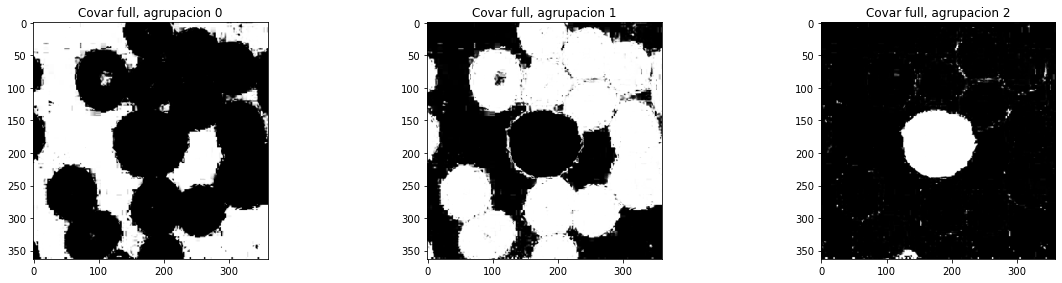

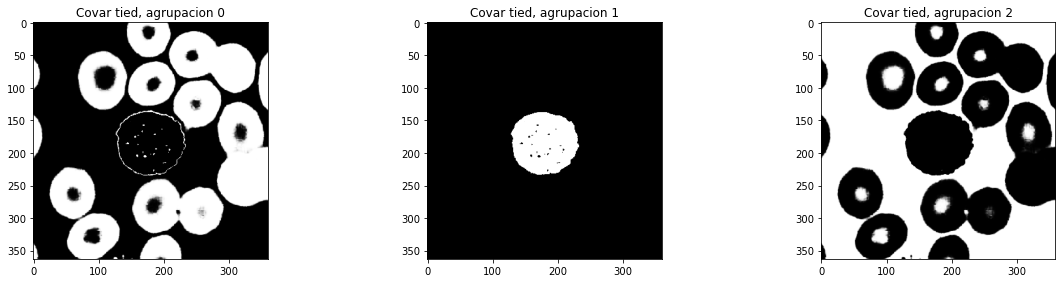

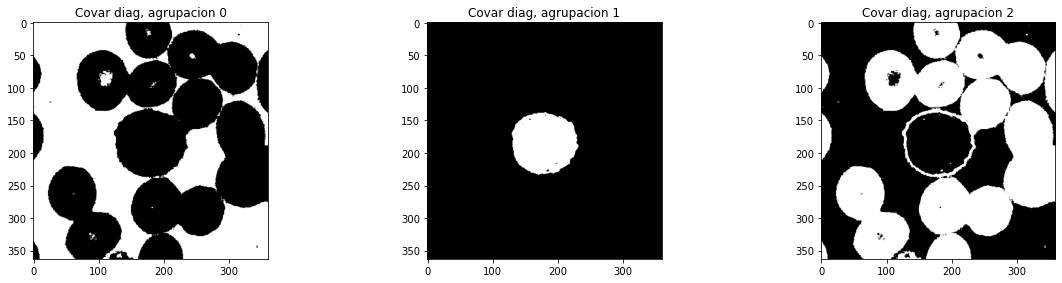

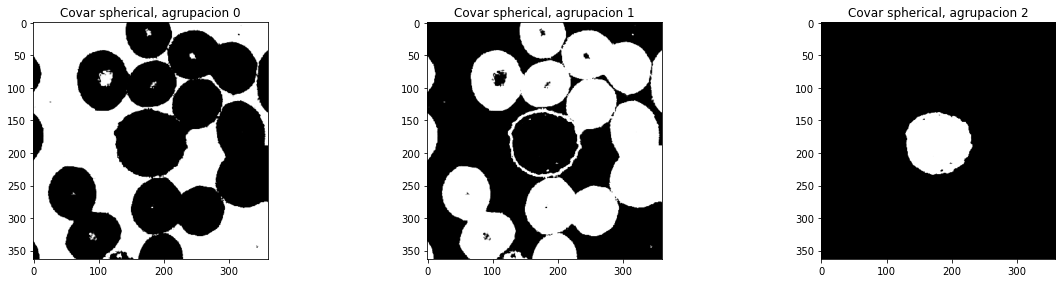

In [7]:
k = 0
for j in range(4):
    pred = preds[j]
    plt.figure(figsize = (20,20))
    for i in range(3):
        plt.subplot(4, 3,k+1), plt.imshow(pred[:,:,i], cmap='gray')
        plt.title(f"Covar {covars[j]}, agrupacion {i}")
        k = k+1
    plt.show()

- Definitivamente usar coverianza `full` no es buena idea para la segmentacion, puesto que las imagenes no salen muy claras.
- Los demas tipos de covarianzas parecen funcionar mucho mejor, pero quien proporciona una mejor segmentacion es la covarianza `tied`

## Punto 3 y 4

- Observe que a medida que sube el número de componentes en GMM, la métrica BIC va bajando, además de esto la segmentación debería irse refinando.
- Por otro lado, se puede observar que en definitiva, un BIC mas bajo conlleva una mejor segmentacion, y visualmente se puede comprobrar
- Por último, como el núcleo no logra segmentarse, una manera de segmentarse rápidamente, es subiendo el número de componentes, ya que por las razones descritas anteriormente, el BIC será más bajo y la segmentación será más notoria.
- Visualmente notara que con 6 componentes el núcleo ya empieza a segmentarse un poco, y con 12 componentes ya se ve el núcleo segmentado.

In [8]:
chosen = "tied"

n_components = [3,4,6,12]
models = [GaussianMixture(n_components=i, covariance_type= chosen ).fit(df) for i in n_components]
preds  = [ models[i].predict_proba(df).reshape(363,360,n_components[i]) for i in range(len(n_components)) ]

for i in range(len(n_components)):    
    print(f"{n_components[i]} componentes --> {models[i].bic(df)}")


3 componentes --> 2736538.2042864785
4 componentes --> 2733676.947577397
6 componentes --> 2728366.9952089414
12 componentes --> 2579262.2000546465


### 3 Componentes

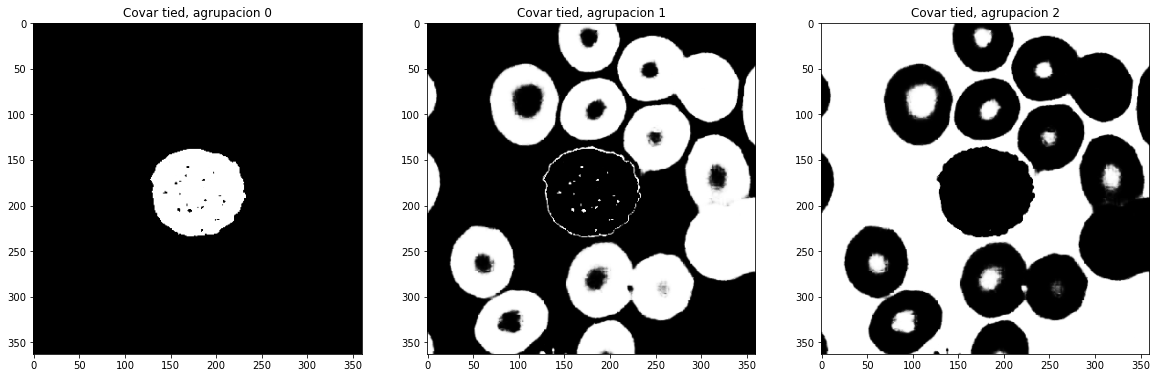

In [10]:
plt.figure(figsize = (20,20))
for i in range(3):  
        plt.subplot(1, 3,i+1), plt.imshow(preds[0][:,:,i], cmap='gray')
        plt.title(f"Covar {chosen}, agrupacion {i}")
        k = k+1

### 4 Componentes

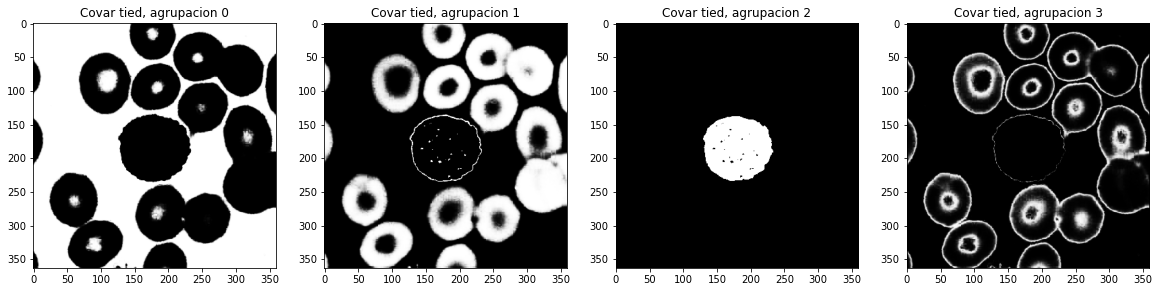

In [11]:
plt.figure(figsize = (20,20))
for i in range(4):  
        plt.subplot(1, 4,i+1), plt.imshow(preds[1][:,:,i], cmap='gray')
        plt.title(f"Covar {chosen}, agrupacion {i}")
        k = k+1

### 6 Componentes

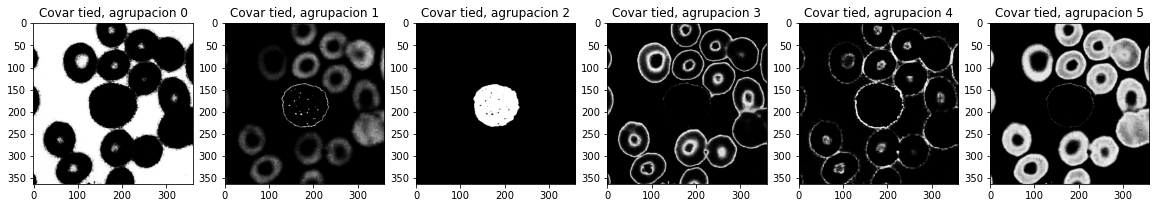

In [12]:
plt.figure(figsize = (20,20))
for i in range(6):  
        plt.subplot(1, 6,i+1), plt.imshow(preds[2][:,:,i], cmap='gray')
        plt.title(f"Covar {chosen}, agrupacion {i}")
        k = k+1

### 12 Componentes

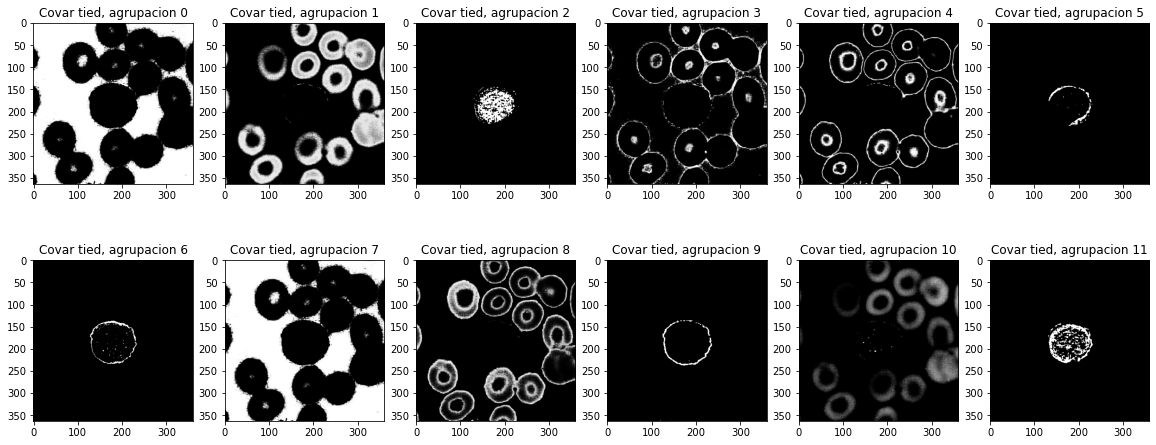

In [13]:
k = 0
plt.figure(figsize = (20,8))
for i in range(12):
    plt.subplot(2, 6,k+1), plt.imshow(preds[3][:,:,i], cmap='gray')
    plt.title(f"Covar {chosen}, agrupacion {i}")
    k = k+1
plt.show()

## Punto 5

- Se implementó una función que recibe el tipo de covarianza, numero de componentes, y una lista con los nombres de las imágenes a segmentar. Esta función abre cada imagen y saca un modelo con el tipo de covarianza y numero de componentes especificado.
- La función presume que las imágenes están guardadas dentro de la carpeta data_test.


In [1]:
def segment_img(n_comp,images,covar):
    BIC = []
    k = 0
    for image in images:
        
        #Open Image
        im = Image.open(f"data_test/{image}")
        
        #Image to array
        im = np.asarray(im)
        
        #reshape imagen
        df = im.reshape((363*360,3))
        
        #GMM
        model = GaussianMixture(n_components=n_comp, covariance_type= covar ).fit(df)
        pred = model.predict_proba(df).reshape(363,360,n_comp)
        
        #BIC
        BIC.append(model.bic(df))
        
        #plot
        plt.figure(figsize = (20,60))
        ax = fig.add_subplot(11,2, i+1)
        ax.imshow(pred[:,:,i], cmap='gray')
        ax.set_title(f"{image}")
        k = k+1
        plt.show()
    return BIC

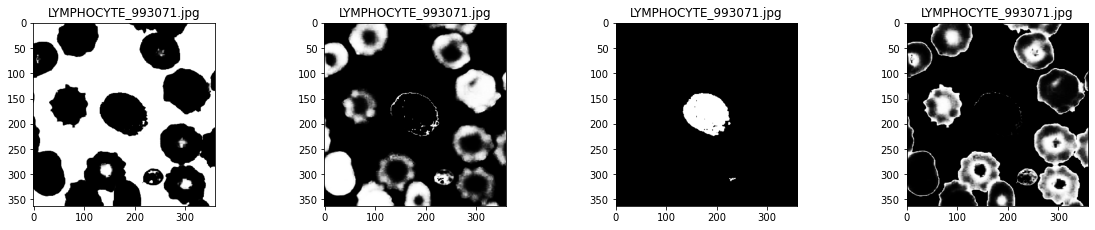

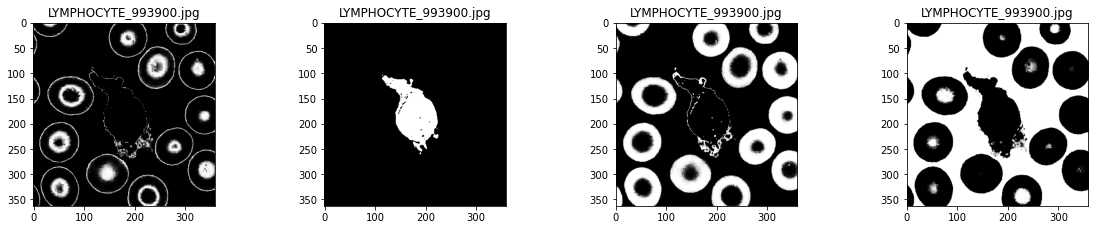

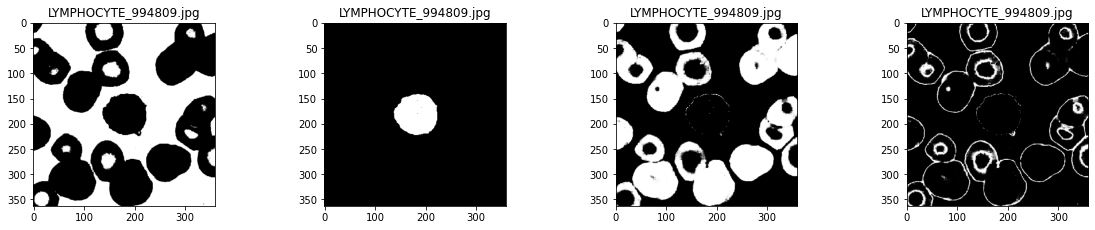

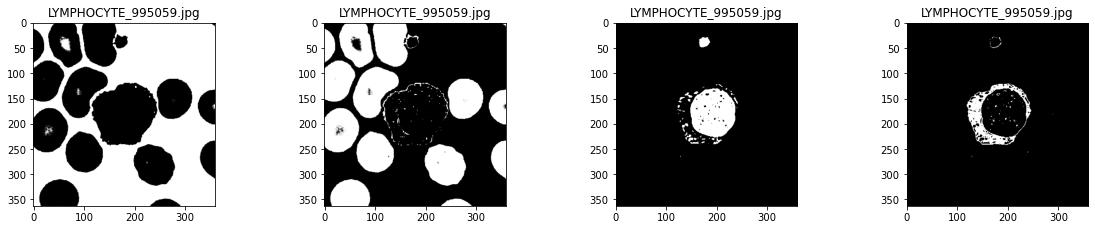

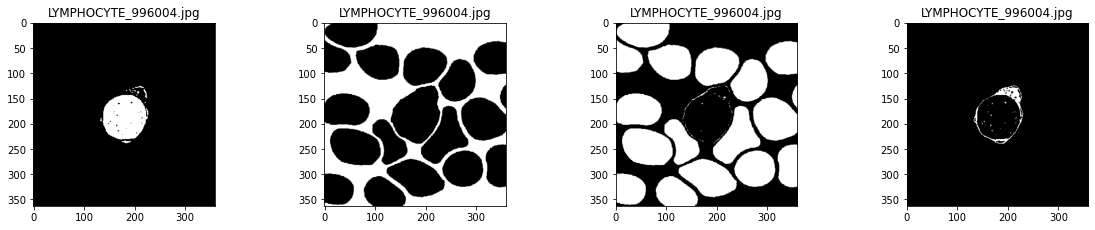

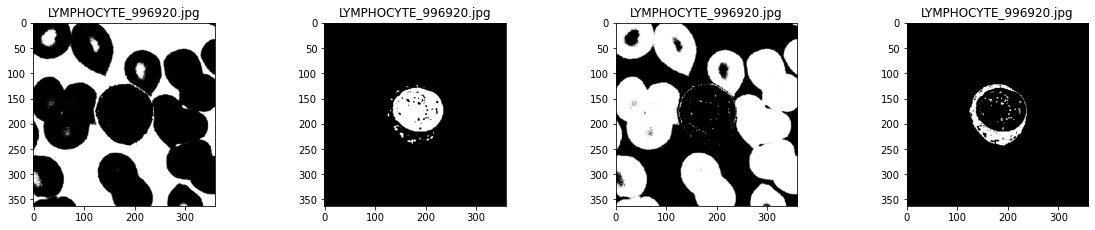

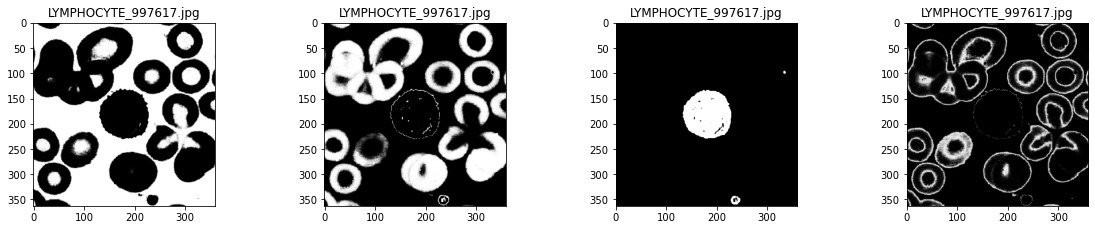

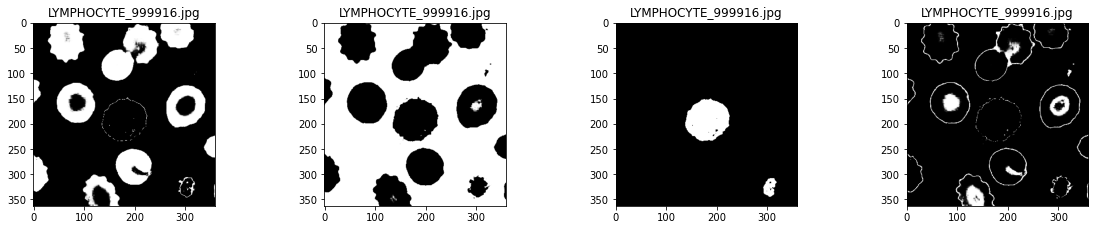

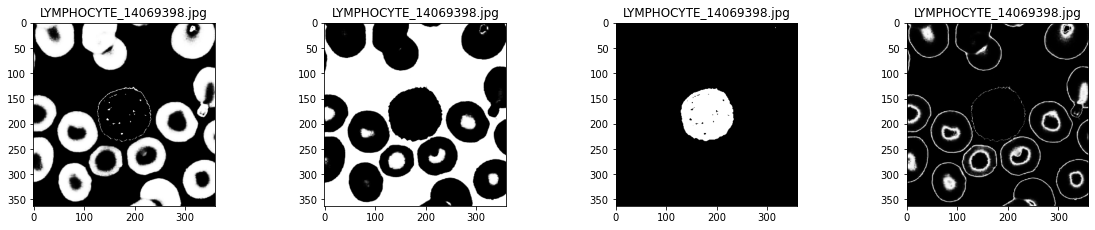

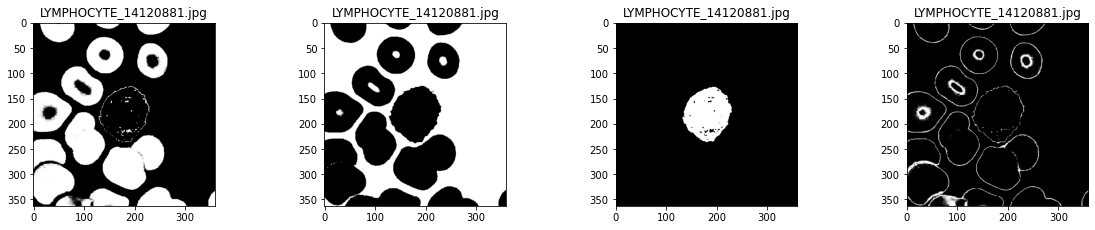

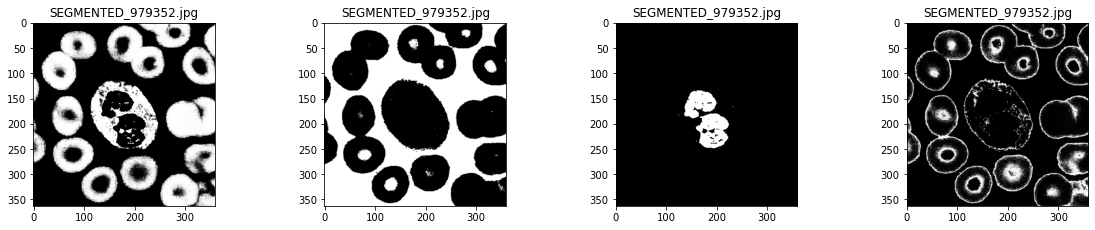

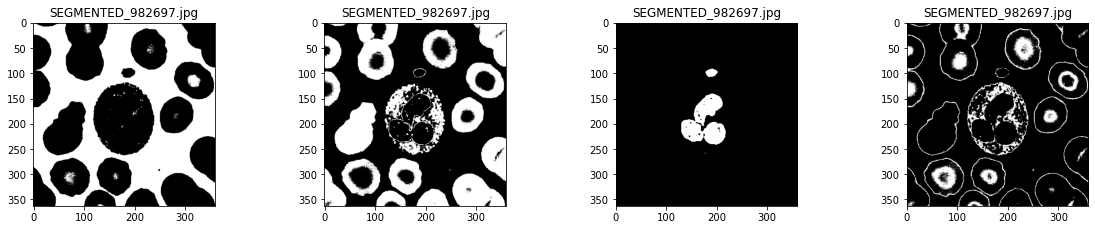

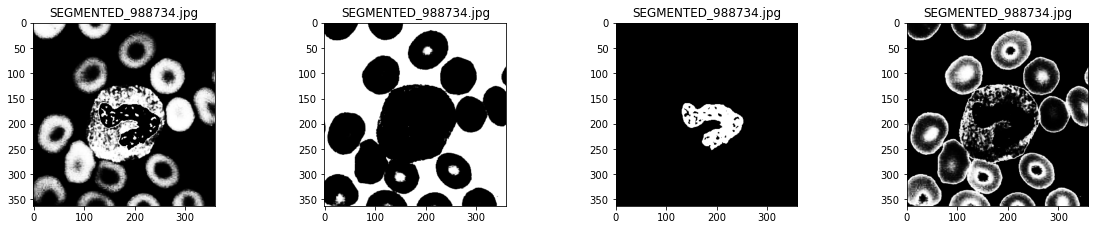

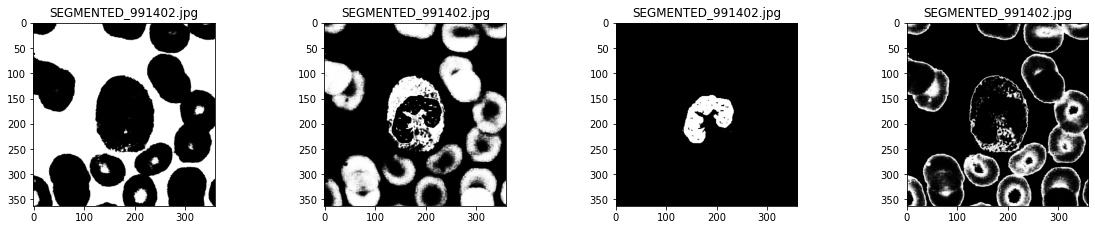

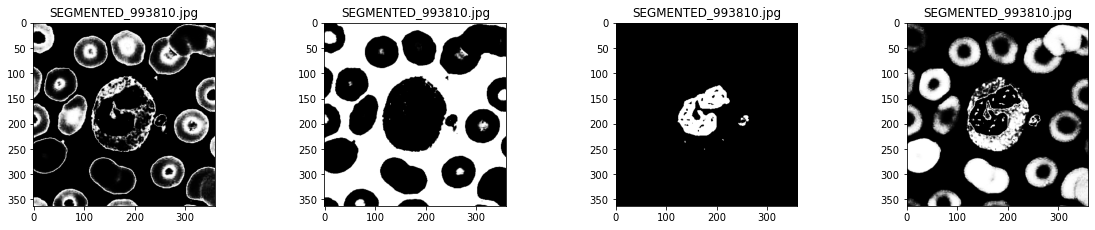

In [4]:
#Nombres de las imagenes
name_images = ["LYMPHOCYTE_993071.jpg","LYMPHOCYTE_993900.jpg","LYMPHOCYTE_994809.jpg","LYMPHOCYTE_995059.jpg","LYMPHOCYTE_996004.jpg","LYMPHOCYTE_996920.jpg","LYMPHOCYTE_997617.jpg","LYMPHOCYTE_999916.jpg","LYMPHOCYTE_14069398.jpg","LYMPHOCYTE_14120881.jpg","SEGMENTED_979352.jpg","SEGMENTED_982697.jpg","SEGMENTED_988734.jpg","SEGMENTED_991402.jpg","SEGMENTED_993810.jpg"]

#Parametros
n_componentes = 4
tipo_covarianza = "tied"

#se segmentan las imagenes
BICs = segment_img(n_componentes,name_images,tipo_covarianza)

### Valores BIC

array([<AxesSubplot:title={'center':'0'}>], dtype=object)

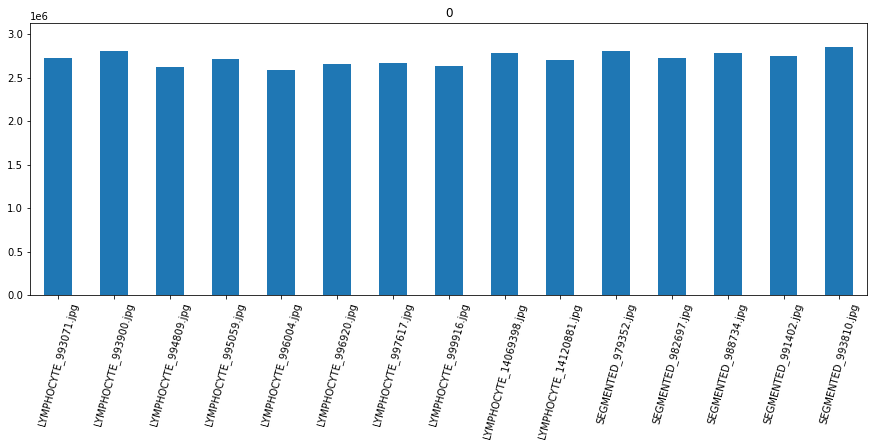

In [16]:
import pandas as pd

d = pd.DataFrame([BICs],columns=name_images).loc[0,name_images]
d.plot.bar(subplots=True,rot=75,ylim = (0,d.max() + d.mean()/10 ),figsize=(15,5) )